In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt

2023-09-09 17:29:46.784781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders_v2 import *

## Helper functions

In [3]:
# def create_tf_datasets(input_data, output_data):
#     # Convert xarray dataset to numpy array for TensorFlow Dataset
#     input_images = input_data.transpose('time', 'lat', 'lon','channel').values
#     output_one_hot = output_data.values

#     # Create TensorFlow Datasets
#     input_dataset = tf.data.Dataset.from_tensor_slices(input_images)
#     output_dataset = tf.data.Dataset.from_tensor_slices(output_one_hot)

#     # Combine input and output datasets into a joint dataset
#     joint_dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

#     return joint_dataset
def create_tf_datasets(input_data, output_data):
    # Convert xarray dataset to numpy array for TensorFlow Dataset
    input_images = input_data.transpose('time', 'lat', 'lon','channel').values
    output_one_hot = output_data.values

    # Create TensorFlow Datasets
    input_dataset = tf.data.Dataset.from_tensor_slices(input_images)
    output_dataset = tf.data.Dataset.from_tensor_slices(output_one_hot)

    # Combine input and output datasets into a joint dataset
    joint_dataset = tf.data.Dataset.zip((input_dataset, output_dataset))

    return (input_images,output_one_hot)

def create_datasets(input_anoms, var_name, df_shifts, week_out):
# Assuming you have the xarray.Dataset 'input_data' and the pandas.Series 'output_data'
    input_data = copy.deepcopy(input_anoms[var_name])

    array_temp = input_data.data
    array_temp[np.isfinite(array_temp)==False]=0
    input_data.data = array_temp

#     input_data = (input_data - input_data.mean('time')) / (input_data.std('time'))
    
#     input_data[np.isfinite(array_temp)==False] = 0
    
    # Reshape the data to add a new dimension
    values_reshaped = input_data.values.reshape(input_data.shape[0], input_data.shape[1], input_data.shape[2], 1)

    # Create a new xarray.DataArray with the reshaped data and the original coordinates
    input_data = xr.DataArray(values_reshaped, coords=input_data.coords, dims=('time', 'lat', 'lon', 'channel'))
    output_data = copy.deepcopy(df_shifts[f'week{week_out}']).dropna()

    # Step 1: Create a common date index that includes all dates in both the input and output data
    common_dates = np.intersect1d(input_data['time'].values, output_data.index)

    # Step 2: Reindex the input xarray dataset and the output DataFrame to the common date index
    input_data = input_data.sel(time=common_dates)
    output_data = output_data.loc[common_dates]

    # Step 3: One-hot encode the output DataFrame using to_categorical
    num_classes = len(output_data.unique())  # Number of classes (number of weeks in this case)
    output_data_encoded = to_categorical(output_data, num_classes=num_classes)
    output_data_encoded = pd.DataFrame(output_data_encoded,index=output_data.index)

    # Step 4: Create masks for training, validation, and testing periods
    train_mask = (output_data.index >= '1980-01-01') & (output_data.index <= '2010-12-31')
    val_mask = (output_data.index >= '2011-01-01') & (output_data.index <= '2015-12-31')
    test_mask = (output_data.index >= '2016-01-01') & (output_data.index <= '2020-12-31')

    # Step 5: Split the input xarray dataset and the output DataFrame into subsets
    input_train = input_data.sel(time=train_mask)
    input_val = input_data.sel(time=val_mask)
    input_test = input_data.sel(time=test_mask)

    output_train = output_data_encoded.loc[train_mask]
    output_val = output_data_encoded.loc[val_mask]
    output_test = output_data_encoded.loc[test_mask]

    train_joint_dataset = create_tf_datasets(input_train, output_train)
    val_joint_dataset = create_tf_datasets(input_val, output_val)
    test_joint_dataset = create_tf_datasets(input_test, output_test)

    # buffer_size = train_joint_dataset.cardinality()
    # train_joint_dataset = train_joint_dataset.shuffle(buffer_size)
    return train_joint_dataset, val_joint_dataset, test_joint_dataset

def get_output_from_dataset(dataset):
    output_array = []
    for input_data, output_data in dataset.as_numpy_iterator():
        output_array.append(output_data)

    # Convert the list of NumPy arrays into a single NumPy array
    output_array = np.array(output_array)
    return output_array

def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(balanced_accuracy_score, (y_true, y_pred), tf.float32)

def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [4]:
def create_datasets_multichannel(input_data, df_shifts, week_out):
# Assuming you have the xarray.Dataset 'input_data' and the pandas.Series 'output_data'

    # Create a new xarray.DataArray with the reshaped data and the original coordinates
    output_data = copy.deepcopy(df_shifts[f'week{week_out}']).dropna()

    # Step 1: Create a common date index that includes all dates in both the input and output data
    common_dates = np.intersect1d(input_data['time'].values, output_data.index)

    # Step 2: Reindex the input xarray dataset and the output DataFrame to the common date index
    input_data = input_data.sel(time=common_dates)
    output_data = output_data.loc[common_dates]

    # Step 3: One-hot encode the output DataFrame using to_categorical
    num_classes = len(output_data.unique())  # Number of classes (number of weeks in this case)
    output_data_encoded = to_categorical(output_data, num_classes=num_classes)
    output_data_encoded = pd.DataFrame(output_data_encoded,index=output_data.index)

    # Step 4: Create masks for training, validation, and testing periods
    train_mask = (output_data.index >= '1980-01-01') & (output_data.index <= '2010-12-31')
    val_mask = (output_data.index >= '2011-01-01') & (output_data.index <= '2015-12-31')
    test_mask = (output_data.index >= '2016-01-01') & (output_data.index <= '2020-12-31')

    # Step 5: Split the input xarray dataset and the output DataFrame into subsets
    input_train = input_data.sel(time=train_mask)
    input_val = input_data.sel(time=val_mask)
    input_test = input_data.sel(time=test_mask)

    output_train = output_data_encoded.loc[train_mask]
    output_val = output_data_encoded.loc[val_mask]
    output_test = output_data_encoded.loc[test_mask]

    train_joint_dataset = create_tf_datasets(input_train, output_train)
    val_joint_dataset = create_tf_datasets(input_val, output_val)
    test_joint_dataset = create_tf_datasets(input_test, output_test)

    return train_joint_dataset, val_joint_dataset, test_joint_dataset

# Training

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## GLOBAL SEED ##    
np.random.seed(42)
tf.random.set_seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-09-09 17:29:54.739047: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-09 17:29:54.740393: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-09 17:29:54.766004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-09 17:29:54.766043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-09-09 17:29:54.872426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-09-09 17:29:54.872502: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

IC_SODA.nc   OHC100_SODA.nc  OHC50_SODA.nc   SD_ERA5.nc      SST_SODA.nc       STL_7cm_ERA5.nc   SWVL_28cm_ERA5.nc  U10_ERA5.nc
IT_SODA.nc   OHC200_SODA.nc  OHC700_SODA.nc  SSH_SODA.nc     STL_1m_ERA5.nc    STL_full_ERA5.nc  SWVL_7cm_ERA5.nc   U200_ERA5.nc
MLD_SODA.nc  OHC300_SODA.nc  OLR_ERA5.nc     SST_OISSTv2.nc  STL_28cm_ERA5.nc  SWVL_1m_ERA5.nc   SWVL_full_ERA5.nc  Z500_ERA5.ncm

In [6]:
path_models = '/glade/work/jhayron/Data4Predictability/models/CNN_Sep9_2023/test_4var/'

In [7]:
names_vars = ['Z500_ERA5','OLR_ERA5','U200_ERA5','U10_ERA5']

path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd/'
# path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms_Std_withTrends/'

list_input_anoms = []

var_names = []
for name_var in names_vars:
    list_input_anoms.append(xr.open_dataset(f'{path_weekly_anoms}{name_var}.nc'))
    var_names.append(list(list_input_anoms[-1].data_vars.keys())[0])
    
full_input_array = np.zeros((list_input_anoms[0][var_names[0]].values.shape[0],240,720,len(list_input_anoms)))

for ichannel in range(len(list_input_anoms)):
    full_input_array[:,:,:,ichannel] = list_input_anoms[ichannel][var_names[ichannel]].values
    
full_input_array[np.isfinite(full_input_array)==False]=0

da_input = xr.DataArray(
    data=full_input_array,
    dims=["time","lat", "lon","channel"],
    coords=dict(
        time=(["time"], list_input_anoms[0][var_names[0]].time.values),
        lat=(["lat"], list_input_anoms[0][var_names[0]].lat.values),
        lon=(["lon"], list_input_anoms[0][var_names[0]].lon.values),
        channel=(["channel"], np.arange(full_input_array.shape[-1])),
    )
)

reduction_factor = 4
coarsened_data = da_input.coarsen(lat=reduction_factor, lon=reduction_factor).mean()

del(full_input_array)
del(list_input_anoms)
del(var_names)

week_out=3
week_out_str = f'week{week_out}'

wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)
        
train_joint_dataset, val_joint_dataset, test_joint_dataset = \
    create_datasets_multichannel(coarsened_data, df_shifts, week_out)
del(da_input)

2023-09-09 17:33:08.369321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 17:33:08.369442: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-09 17:33:08.370013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-09-09 17:33:08.370068: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-09-09 17:33:08.370102: I tensorflow/stream_executor/platfor

In [8]:
index_random = np.arange(len(train_joint_dataset[0]))
np.random.shuffle(index_random)

In [10]:
list_acc = []
list_balanced_acc = []
for train_i in [1,2,3]:
    dict_params = {'model_base':'densenet',
                   'type_pooling':'avg',
                   'do':0.5,
                   'md':8,
                   'activation':'LeakyReLU',
                   'weighted_loss':True,
                   'bs':32,
                   'lr':0.001,
                   'input_shape':train_joint_dataset[0].shape[1:]}
    # with strategy.scope():
    model = build_predesigned_model(dict_params['model_base'],
                                    dict_params['type_pooling'],
                                    dict_params['do'],
                                    dict_params['md'],
                                    dict_params['activation'],
                                    dict_params['input_shape'])

    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(lr=dict_params['lr']),
                  metrics=[balanced_accuracy,'accuracy'])  

    epochs = 100
    early_stopping_patience = 5

    # Create the EarlyStopping callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_balanced_accuracy',  # Metric to monitor
        patience=early_stopping_patience,  # Number of epochs with no improvement
        restore_best_weights=True  # Restore the weights of the best model
    )

    # Train the model with early stopping
    try:
        os.mkdir(f'{path_models}{name_var}')
    except: pass

    filepath = f'{path_models}{name_var}/model_{week_out_str}_v0.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                 mode='auto',save_weights_only=False)


    if dict_params['weighted_loss']==True:

        y_train = copy.deepcopy(train_joint_dataset[1])
        y_train_integers = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_integers),
                                             y = y_train_integers)
        d_class_weights = dict(enumerate(class_weights))

        history = model.fit(
            train_joint_dataset[0][index_random],
            train_joint_dataset[1][index_random],
            batch_size=dict_params['bs'],
            validation_data=val_joint_dataset,
            class_weight = d_class_weights,
            epochs=epochs,
            callbacks=[checkpoint,early_stopping_callback],
            verbose=0
        )
    else:
        history = model.fit(
            train_joint_dataset[0][index_random],
            train_joint_dataset[1][index_random],
            batch_size=dict_params['bs'],
            validation_data=val_joint_dataset,
            epochs=epochs,
            callbacks=[checkpoint,early_stopping_callback],
            verbose=0
        )

    ### test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset.batch(len(test_joint_dataset)/5))
    test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset[0],test_joint_dataset[1],
                                                                      verbose=0)
    # test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset)
    val_balanced_accuracy = np.max(history.history['val_balanced_accuracy'])
    val_accuracy = np.max(history.history['val_accuracy'])
    print(f'**iteration: {train_i}**')
    print('test_balanced_accuracy',test_balanced_accuracy)
    print('test_accuracy',test_accuracy)
    print('val_balanced_accuracy',val_balanced_accuracy)
    print('val_accuracy',val_accuracy)
    list_acc.append(test_accuracy)
    list_balanced_acc.append(test_balanced_accuracy)
print("AVERAGE RESULTS (acc,balanced_acc): ")
print(np.mean(list_acc),np.mean(list_balanced_acc))

2023-09-09 17:33:57.103614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-09 17:33:57.104049: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-09-09 17:34:10.529704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-09-09 17:34:10.746163: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


**iteration: 1**
test_balanced_accuracy 0.22215120494365692
test_accuracy 0.20158103108406067
val_balanced_accuracy 0.25614234805107117
val_accuracy 0.2260536402463913
**iteration: 2**
test_balanced_accuracy 0.24509651958942413
test_accuracy 0.26284584403038025
val_balanced_accuracy 0.2516455054283142
val_accuracy 0.26436781883239746
**iteration: 3**
test_balanced_accuracy 0.24407365918159485
test_accuracy 0.197628453373909
val_balanced_accuracy 0.24302451312541962
val_accuracy 0.2816092073917389
AVERAGE RESULTS (acc,balanced_acc): 
0.22068510949611664 0.23710712790489197


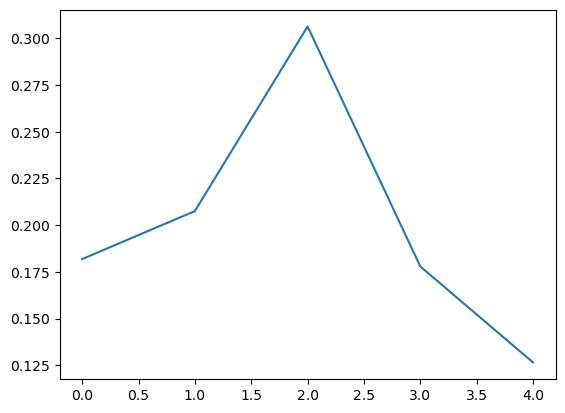

In [11]:
plt.plot(np.sum(test_joint_dataset[1],axis=0)/ np.sum(test_joint_dataset[1]))

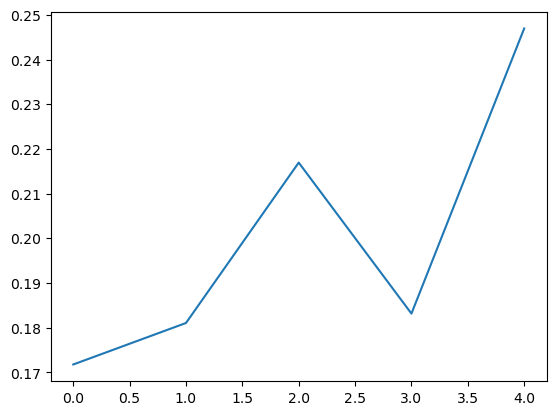

In [12]:
predictions = model.predict(test_joint_dataset[0])
plt.plot(np.mean(predictions,axis=0))

In [10]:
# resnet50 - 0.2325156182050705


In [11]:
# test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset.batch(len(test_joint_dataset)/5))
test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset[0],test_joint_dataset[1])
# test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(test_joint_dataset)
val_balanced_accuracy = np.max(history.history['val_balanced_accuracy'])
val_accuracy = np.max(history.history['val_accuracy'])

print('test_balanced_accuracy',test_balanced_accuracy)
print('test_accuracy',test_accuracy)
print('val_balanced_accuracy',val_balanced_accuracy)
print('val_accuracy',val_accuracy)

16/16 [==============================] - 5s 227ms/step - loss: 1.6092 - balanced_accuracy: 0.2063 - accuracy: 0.1779
test_balanced_accuracy 0.20625002682209015
test_accuracy 0.17786560952663422
val_balanced_accuracy 0.21481484174728394
val_accuracy 0.24137930572032928


In [25]:
train_joint_dataset.batch(dict_params['bs'])

<BatchDataset shapes: ((None, 240, 720, 1), (None, 5)), types: (tf.float64, tf.float32)>

In [48]:
input_data.numpy().shape

(240, 720, 1)

In [14]:
# Assuming your dataset is called 'test_dataset'
all_input_data = []
all_output_data = []

for input_data, output_data in test_joint_dataset:
    all_input_data.append(input_data.numpy())  # Convert the Tensor to a NumPy array
    all_output_data.append(output_data.numpy())
# Convert the list of NumPy arrays to a single NumPy array
all_input_data_np = np.array(all_input_data)
all_output_data_np = np.array(all_output_data)

In [13]:
model.predict(all_input_data_np)

array([[0.19588202, 0.20458117, 0.19893521, 0.19674964, 0.20385192],
       [0.19588204, 0.2045812 , 0.19893523, 0.19674964, 0.20385194],
       [0.19588202, 0.20458117, 0.19893521, 0.19674964, 0.20385192],
       ...,
       [0.19588202, 0.20458117, 0.19893521, 0.19674964, 0.20385192],
       [0.19588202, 0.20458117, 0.19893521, 0.19674964, 0.20385192],
       [0.19588202, 0.20458117, 0.19893521, 0.19674964, 0.20385192]],
      dtype=float32)

In [19]:
all_input_data_np[0]

array([[[1.46623502],
        [1.48863234],
        [1.5077076 ],
        ...,
        [1.38798114],
        [1.41586549],
        [1.44197845]],

       [[1.54025296],
        [1.55970751],
        [1.57487297],
        ...,
        [1.46626309],
        [1.49324022],
        [1.51785905]],

       [[1.60578687],
        [1.62109075],
        [1.63273157],
        ...,
        [1.54104955],
        [1.565385  ],
        [1.58693654]],

       ...,

       [[0.67280749],
        [0.6718265 ],
        [0.67083733],
        ...,
        [0.67573343],
        [0.67476368],
        [0.67378126]],

       [[0.64225224],
        [0.64167656],
        [0.64109503],
        ...,
        [0.64397349],
        [0.64339685],
        [0.64282955]],

       [[0.61313806],
        [0.61294637],
        [0.61276231],
        ...,
        [0.61369119],
        [0.61350686],
        [0.61332178]]])

In [15]:
all_output_data_np

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [65]:
all_input_data_np.shape

(522, 240, 720, 1)

In [36]:
len(np.where(np.isfinite(input_data.numpy()[:,:,0])==False)[0])

0

In [38]:
output_data.numpy()

array([0., 1., 0., 0., 0.], dtype=float32)

In [57]:
train_joint_dataset.cardinality

<bound method DatasetV2.cardinality of <ShuffleDataset shapes: ((240, 720, 1), (5,)), types: (tf.float64, tf.float32)>>

In [ ]:
path_models = '/glade/work/jhayron/Data4Predictability/models/CNN_Aug17_2023/v0/'
optimizer_direction = 'maximize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 0.12*60*60  # seconds

In [ ]:
,name_var,week_out_str

In [ ]:
class Objective(object):
    def __init__(self, train_joint_dataset, val_joint_dataset, test_joint_dataset,
                 path_models, variable, week):
        self.train_joint_dataset = train_joint_dataset
        self.val_joint_dataset = val_joint_dataset
        self.test_joint_dataset = test_joint_dataset
        self.path_models = path_models
        self.variable = variable
        self.week = week
 
    def __call__(self, trial):    
        keras.backend.clear_session()
        
        model_base = trial.suggest_categorical('model_base',['vanilla','resnet50','resnet101',\
                                                             'inception','xception','densenet'])
        ks = trial.suggest_categorical('ks',[3,5,7,9,11])
        ps = trial.suggest_categorical('ps',[2,4,6,8])
        type_pooling = trial.suggest_categorical('type_pooling',[None, 'avg','max'])
        stc = trial.suggest_categorical('stc',[1,2,3,4])
        stp = trial.suggest_categorical('stp',[1,2,3,4])
        do = trial.suggest_categorical('do',[0.3,0.4,0.5])
        md = trial.suggest_categorical('md',[2,4,8,16])
        nfilters = trial.suggest_categorical('nfilters',[4,8,16,32])
        activation = trial.suggest_categorical('activation',['LeakyReLU','ReLU'])
        weighted_loss = trial.suggest_categorical('weighted_loss',[True,False])
        
        dict_params = {'model_base':model_base,
                       'ks':ks,
                       'ps':ps,
                       'type_pooling':type_pooling,
                       'stc':stc,
                       'stp':stp,
                       'do':do,
                       'md':md,
                       'nfilters':nfilters,
                       'activation':activation,
                       'weighted_loss':weighted_loss}
        print(dict_params)                                      
        # instantiate and compile model
        if dict_params['model_base']=='vanilla':
            model = build_vanilla_cnn(dict_params['ks'],
                                      dict_params['ps'],
                                      dict_params['type_pooling'],
                                      dict_params['stc'],
                                      dict_params['stp'],
                                      dict_params['do'],
                                      dict_params['md'],
                                      dict_params['nfilters'],
                                      dict_params['activation'])
        elif dict_params['model_base']=='resnet50':
            model = build_resnet50_model(dict_params['type_pooling'],
                                         dict_params['do'],
                                         dict_params['md'],
                                         dict_params['activation'])
        elif dict_params['model_base']=='resnet101':
            model = build_resnet101_model(dict_params['type_pooling'],
                                         dict_params['do'],
                                         dict_params['md'],
                                         dict_params['activation'])
        elif dict_params['model_base']=='inception':
            model = build_inception_model(dict_params['type_pooling'],
                                         dict_params['do'],
                                         dict_params['md'],
                                         dict_params['activation'])
        elif dict_params['model_base']=='xception':
            model = build_xception_model(dict_params['type_pooling'],
                                         dict_params['do'],
                                         dict_params['md'],
                                         dict_params['activation'])
        elif dict_params['model_base']=='densenet':
            model = build_densenet_model(dict_params['type_pooling'],
                                         dict_params['do'],
                                         dict_params['md'],
                                         dict_params['activation'])
            
        model.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(lr=0.0001),metrics=[balanced_accuracy,'accuracy'])
        
        epochs = 100
        early_stopping_patience = 5

        # Create the EarlyStopping callback
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_balanced_accuracy',  # Metric to monitor
            patience=early_stopping_patience,  # Number of epochs with no improvement
            restore_best_weights=True  # Restore the weights of the best model
        )

        # Train the model with early stopping
        try:
            os.mkdir(f'{self.path_models}{self.variable}')
        except: pass
    
        filepath = f'{self.path_models}{self.variable}/model_{self.week}_v0.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                     mode='auto',save_weights_only=False)
        
        if dict_params['weighted_loss']==True:
            
            y_train = get_output_from_dataset(self.train_joint_dataset)
            y_train_integers = np.argmax(y_train, axis=1)
            class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_integers),
                                                 y = y_train_integers)
            d_class_weights = dict(enumerate(class_weights))
            
            history = model.fit(
                self.train_joint_dataset.batch(32),
                validation_data=self.val_joint_dataset.batch(32),
                class_weight = d_class_weights,
                epochs=epochs,
                callbacks=[checkpoint,early_stopping_callback],
                verbose=0
            )
        else:
            history = model.fit(
                self.train_joint_dataset.batch(32),
                validation_data=self.val_joint_dataset.batch(32),
                epochs=epochs,
                callbacks=[checkpoint,early_stopping_callback],
                verbose=0
            )
        
        test_loss, test_balanced_accuracy, test_accuracy = model.evaluate(self.test_joint_dataset.batch(32))
        val_balanced_accuracy = np.max(history.history['val_balanced_accuracy'])
        val_accuracy = np.max(history.history['val_accuracy'])
        
        trial.set_user_attr('test_balanced_accuracy',test_balanced_accuracy)
        trial.set_user_attr('test_accuracy',test_accuracy)
        trial.set_user_attr('val_balanced_accuracy',val_balanced_accuracy)
        trial.set_user_attr('val_accuracy',val_accuracy)
        
        return val_balanced_accuracy
    
    
# Get variable and origin from command-line arguments
name_var = sys.argv[1]
week_out = sys.argv[2]
path_weekly_anoms = '/glade/scratch/jhayron/Data4Predictability/WeeklyAnoms/'
input_anoms = xr.open_dataset(f'{path_weekly_anoms}{name_var}.nc')
var_name = list(input_anoms.data_vars.keys())[0]
week_out_str = f'week{week_out}'

wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)
        
train_joint_dataset, val_joint_dataset, test_joint_dataset = \
    create_datasets(input_anoms, var_name, df_shifts, week_out)
path_models = '/glade/work/jhayron/Data4Predictability/models/CNN/v0/'
optimizer_direction = 'maximize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 0.12*60*60  # seconds
objective = Objective(train_joint_dataset,val_joint_dataset,test_joint_dataset,
                      path_models,name_var,week_out_str)
    
results_directory = f'/glade/work/jhayron/Data4Predictability/models/CNN/results_optuna/{week_out_str}/'
try:
    os.mkdir(results_directory)
except:
    pass

study_name = f'study_{name_var}_{week_out_str}_v0'
storage_name = f'sqlite:///{study_name}.db'


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction=optimizer_direction,
        sampler=TPESampler(n_startup_trials=number_of_random_points),
        study_name=study_name, storage=storage_name,load_if_exists=True)

study.optimize(objective, timeout=maximum_time, gc_after_trial=True,callbacks=[logging_callback],)

# save results
df_results = study.trials_dataframe()
df_results.to_pickle(results_directory + f'df_optuna_results_{name_var}_v0.pkl')
df_results.to_csv(results_directory + f'df_optuna_results_{name_var}_v0.csv')
#save study
joblib.dump(study, results_directory + f'optuna_study_{name_var}_v0.pkl')